In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install pytesseract transformers datasets evaluate rouge-score nltk tensorboard py7zr --upgrade
# !pip install pytesseract transformers==4.28.1 datasets evaluate rouge-score nltk tensorboard py7zr
!pip install pytesseract transformers==4.28.1 datasets evaluate rouge-score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 11.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
import random
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel, Sequence, load_metric

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
# from unsloth import FastLanguageModel
# from trl import SFTTrainer

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Flan/NER_Datas.csv')
dataset.head()

,tokens,tags
0,ORF,O
1,aspnet_client,O
2,casino,O
3,4.8,I-version
4,3.6.3,B-version


In [5]:
dataset.duplicated().sum()

0

In [6]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to your tags column and transform it
dataset['label'] = label_encoder.fit_transform(dataset['tags'])

# Display the mapping of original tags to labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'B-PL': 0, 'B-application': 1, 'B-cve id': 2, 'B-edition': 3, 'B-file': 4, 'B-function': 5, 'B-hardware': 6, 'B-language': 7, 'B-method': 8, 'B-os': 9, 'B-parameter': 10, 'B-relevant_term': 11, 'B-update': 12, 'B-vendor': 13, 'B-version': 14, 'I-application': 15, 'I-edition': 16, 'I-hardware': 17, 'I-os': 18, 'I-relevant_term': 19, 'I-update': 20, 'I-vendor': 21, 'I-version': 22, 'O': 23}


In [7]:
dataset.head()

,tokens,tags,label
0,ORF,O,23
1,aspnet_client,O,23
2,casino,O,23
3,4.8,I-version,22
4,3.6.3,B-version,14


In [8]:
dataset.drop(columns=['tags'], inplace=True)
dataset.head()

,tokens,label
0,ORF,23
1,aspnet_client,23
2,casino,23
3,4.8,22
4,3.6.3,14


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25827 entries, 0 to 25826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  25826 non-null  object
 1   label   25827 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 403.7+ KB


In [10]:
 # Split the data into training, validation, and test sets
train, X_temp = train_test_split(dataset, test_size=0.10, random_state=42)
validation, test = train_test_split(X_temp, test_size=0.10, random_state=42)

In [11]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

In [12]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  2323 non-null   object
 1   label   2324 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.4+ KB


In [13]:
validation = { 'tokens': [str(text) for text in validation['tokens']] }

In [14]:
 # Create a datasets.Dataset object
train = Dataset.from_dict(train)
validation = Dataset.from_dict(validation)
test = Dataset.from_dict(test)
# Print the dataset to check the format
print("Train Dataset : ",train)
print("Validation Dataset : ", validation)
print("Test Dataset : ", test)

Train Dataset :  Dataset({
    features: ['tokens', 'label'],
    num_rows: 23244
})
Validation Dataset :  Dataset({
    features: ['tokens'],
    num_rows: 2324
})
Test Dataset :  Dataset({
    features: ['tokens', 'label'],
    num_rows: 259
})


In [15]:
# Create DatasetDict
dataset = DatasetDict({
    'validation': validation,
    'test': test,
    'train': train
})
print(dataset)

DatasetDict({
    validation: Dataset({
        features: ['tokens'],
        num_rows: 2324
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 259
    })
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 23244
    })
})


In [16]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens'],
        num_rows: 2324
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 259
    })
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 23244
    })
})

Lets checkout an example of the dataset.

In [17]:
dataset['train']

Dataset({
    features: ['tokens', 'label'],
    num_rows: 23244
})

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id="google/flan-t5-base"

# Load tokenizer of FLAN-t5-base
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

before we can start training we need to preprocess our data. Abstractive flan t5 is good for a text2text-generation task. This means our model will take a text as input and generate a text as output. For this we want to understand how long our input and output will be to be able to efficiently batch our data.
- as result, we should to convert label from int to string

In [19]:
import pandas as pd
from datasets import Dataset
import random

# dataset['train'] = dataset['train'].shuffle(seed=42).select(range(2000))
# dataset['test'] = dataset['test'].shuffle(seed=42).select(range(1000))

dataset['train'] = dataset['train'].shuffle(seed=42)

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
dataset.clear()
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
dataset['train'] = Dataset.from_pandas(train_df)
dataset['test'] = Dataset.from_pandas(test_df)

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 23244
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 259
    })
})

In [21]:
from datasets import concatenate_datasets

# The maximum total input sequence length after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["tokens"], truncation=True), batched=True, remove_columns=['tokens', 'label'])
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["label"], truncation=True), batched=True, remove_columns=['tokens', 'label'])
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

Map:   0%|          | 0/23503 [00:00<?, ? examples/s]

Max source length: 48


Map:   0%|          | 0/23503 [00:00<?, ? examples/s]

Max target length: 3


In [22]:
def preprocess_function(sample, padding="max_length"):
    # add prefix to the input for t5
    inputs = [item for item in sample["tokens"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["label"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=['tokens', 'label'])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Map:   0%|          | 0/23244 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


## 3. Fine-tune and evaluate FLAN-T5



In [23]:
# from transformers import AutoModelForSeq2SeqLM

# # huggingface hub model id
# model_id="google/flan-t5-base"

# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [24]:
import evaluate
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

# Metric
metric = evaluate.load("f1")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, average='macro')
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [25]:
from transformers import DataCollatorForSeq2Seq

# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)


In [26]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Hugging Face repository id
repository_id = "/content/drive/MyDrive/Flan"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=3e-4,

    num_train_epochs=5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    # logging_steps=1000,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=False,
    # metric_for_best_model="overall_f1",
    # push to hub parameters
    # report_to="tensorboard",
    # push_to_hub=True,
    # hub_strategy="every_save",
    # hub_model_id=repository_id,
    # hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

We can start our training by using the `train` method of the `Trainer`.

In [27]:
# Start training
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Gen Len
1,0.555400,0.484453,36.919600,2.000000
2,0.436500,0.451547,37.240300,2.000000
3,0.366400,0.484856,39.922600,2.000000
4,0.310400,0.594996,33.233100,2.000000
5,0.265500,0.696995,35.589200,2.000000


TrainOutput(global_step=14530, training_loss=0.3868269456310758, metrics={'train_runtime': 3192.911, 'train_samples_per_second': 36.399, 'train_steps_per_second': 4.551, 'total_flos': 7460859328266240.0, 'train_loss': 0.3868269456310758, 'epoch': 5.0})

Nice, we have trained our model. 🎉 Lets run evaluate the best model again on the test set.


In [28]:
trainer.evaluate()

{'eval_loss': 0.6969946026802063,
 'eval_f1': 35.5892,
 'eval_gen_len': 2.0,
 'eval_runtime': 3.5772,
 'eval_samples_per_second': 72.403,
 'eval_steps_per_second': 9.225,
 'epoch': 5.0}

In [29]:
# Save our tokenizer and create model card
tokenizer.save_pretrained(repository_id)
trainer.create_model_card()
# Push the results to the hub
# trainer.push_to_hub()

## 4. Run Inference and Classification Report

In [30]:
from tqdm.auto import tqdm

samples_number = len(dataset['test'])
progress_bar = tqdm(range(samples_number))
predictions_list = []
labels_list = []
for i in range(samples_number):
  text = dataset['test']['tokens'][i]
  inputs = tokenizer.encode_plus(text, padding='max_length', max_length=512, return_tensors='pt').to('cuda')
  outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=150, num_beams=4, early_stopping=True)
  prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
  predictions_list.append(prediction)
  labels_list.append(dataset['test']['label'][i])

  progress_bar.update(1)

  0%|          | 0/259 [00:00<?, ?it/s]

In [31]:
str_labels_list = []
for i in range(len(labels_list)): str_labels_list.append(str(labels_list[i]))

In [32]:
from sklearn.metrics import classification_report

report = classification_report(str_labels_list, predictions_list)
print(report)

              precision    recall  f1-score   support

           1       0.34      0.44      0.39        25
          10       0.40      0.57      0.47         7
          11       0.00      0.00      0.00         3
          12       1.00      0.40      0.57         5
          13       0.50      0.18      0.27        11
          14       0.70      0.50      0.58        28
          15       0.14      0.20      0.17        10
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         4
          19       0.00      0.00      0.00         1
           2       1.00      1.00      1.00        13
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          22       0.76      0.97      0.85        36
          23       0.68      0.68      0.68        66
           4       1.00      0.96      0.98        28
           5       0.80      0.80      0.80        15
           6       0.00    

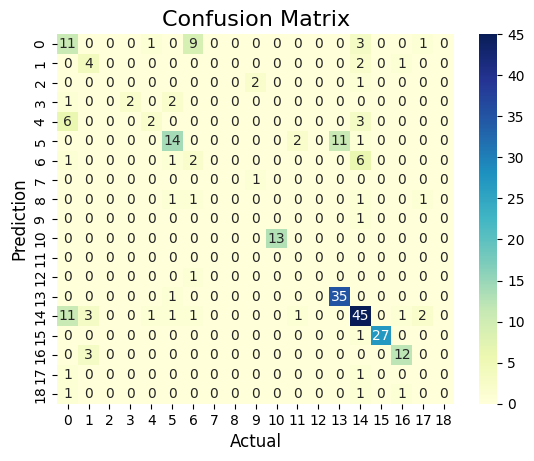

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Create a confusion matrix
cm = confusion_matrix(str_labels_list, predictions_list)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()